In [1]:
import distutils.util
import subprocess


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=wgl

import mujoco

#@title Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Import Renderer Class
import os
import sys

from controller import Controller
from plotter import Plotter

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from renderer import Renderer
model = mujoco.MjModel.from_xml_path('model/world.xml') #cartpole.xml') #humanoid.xml
data = mujoco.MjData(model)
renderer = Renderer(model, width=3072, height=1620)
#renderer = Renderer(model, width=200, height=120)

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
camera_two = mujoco.MjvCamera()
camera_three = mujoco.MjvCamera()

ballJointQPosAddress = model.joint("rotforce").qposadr[0]
ballJointQPos = data.qpos[ballJointQPosAddress]

mujoco.mjv_defaultFreeCamera(model, camera)
camera.lookat=(ballJointQPos,0,0)
camera.distance = 3
camera.azimuth = 160 
camera.elevation = -18 

mujoco.mjv_defaultFreeCamera(model, camera_two)
camera_two.lookat=(ballJointQPos,0,0)
camera_two.distance = 10
camera_two.azimuth = 180
camera_two.elevation = -90

mujoco.mjv_defaultFreeCamera(model, camera_three)
camera_three.lookat=(-1,0,0)
camera_three.distance = 5
camera_three.azimuth = 180
camera_three.elevation = -10

DURATION  = 10   # seconds
FRAMERATE = 60  # Hz

# Controller übernimmt resest Optionen und startet später Optimierung, setzten der Startparameter des Ars und der Kugel
controller = Controller(model, data)
plotter = Plotter(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])

frames = []
frames_two = []
frames_three = []

env: MUJOCO_GL=wgl


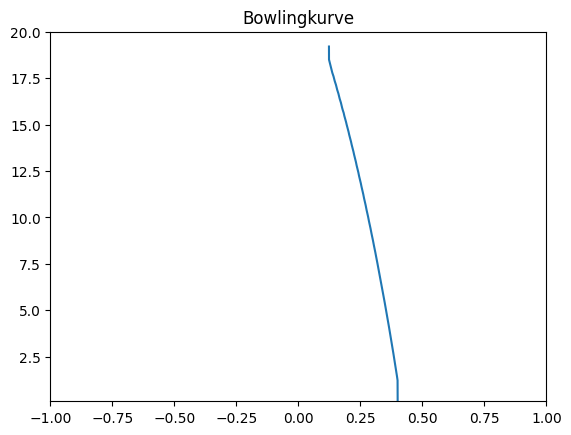

In [2]:
i=-2

while data.time < DURATION:
  # Step the simulation.
    mujoco.mj_step(model, data)
    controller.data = data
    controller.model = model
    model = controller.controlFriction()
    #Start der Simulation, Eingabe der Startwert
    if i == -2:
        model.body("arm").pos = controller.setstartingposarm()
        data.joint("rotforce").qpos = controller.setstartingposball()
        data = controller.startadhesion()
        model = controller.setrotationatstart()
        model = controller.setrangeofarm()
        i = i + 1
        if controller.resetted:
            plotter = Plotter(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])
        
        
    if data.time > 1 and i == -1:
        data.ctrl[model.actuator("schwung").id] = -5
        i = i + 1
        
    if data.time > 3 and i == 0 :
        model = controller.revertrangeofarm()
        data.ctrl[model.actuator("rotation").id] = 0.1
        data.ctrl[model.actuator("schwung").id] = controller.setstartingctrl()
        i = i + 1
        
    if data.qpos[model.joint("rotforce").qposadr] < 19.2 and i == 1:
        model, data = controller.releaseball()
        i = i + 1 
        
    if 0 < data.qpos[model.joint("rotforce").qposadr] < 18.5 and i == 2:
        plotter.updatecurves(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])
        
    if 0.8 > data.qpos[model.joint("rotforce").qposadr]:
        model = controller.checkfalldown()
        data.ctrl[model.actuator("rotation").id] = 0
        model.geom("rollarea").condim = 1
        
    if data.time >= DURATION and not controller.strike() and not controller.resetted:
        media.show_video(frames, fps=FRAMERATE)
        #media.show_video(frames_two, fps = FRAMERATE)
        #media.show_video(frames_three, fps = FRAMERATE)
        plotter.plotcurves()
        # AUSKOMMENTIEREN UM ZWEITE KAMERA AUSZUSCHALTEN
        frames = []
        frames_two = []
        frames_three = []
        mujoco.mj_resetDataKeyframe(model, data, 1)
        model.geom("rollarea").condim = 4
        controller.data = data
        controller.model = model
        data, model = controller.setsecondthrow()
        controller.resetted = True
        data.time = 0
        camera.lookat=(ballJointQPos,0,0)
        camera_two.lookat=(ballJointQPos,0,0)
        i = -2
        
# Render and save frames.    
    if len(frames) < data.time * FRAMERATE:
        
        # KAMERA ALLES AB HIER
        
        ballJointQPosAddress = model.joint("rotforce").qposadr[0]
        ballJointQPos = data.qpos[ballJointQPosAddress]      
        if ballJointQPos > 0 :
            camera.lookat= (ballJointQPos,0,0)
            camera_two.lookat= (ballJointQPos,0,0)       

        
        # KAMERA 1 VIDEO VORBEREITEN
        renderer.update_scene(data, camera)
        pixels = renderer.render()
        frames.append(pixels.copy())
        
        # KAMERA 2 VIDEO VORBEREITEN 
        renderer.update_scene(data, camera_two)
        pixels_two = renderer.render()
        frames_two.append(pixels_two.copy())

        #KAMERA 3 VIDEO VORBEREITEN
        if ballJointQPos < 5 :
            renderer.update_scene(data, camera_three)
            pixels_three = renderer.render()
            frames_three.append(pixels_three.copy())


# VIDEO OUTPUT
media.show_video(frames, fps=FRAMERATE)
plotter.plotcurves()
#media.show_video(frames_two, fps = FRAMERATE)
#media.show_video(frames_three, fps = FRAMERATE)